In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers datasets evaluate seqeval --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 31.3 MB/s eta 0:

In [ ]:
import os
import ast
import json
import shutil
import pickle
import pandas as pd
import numpy as np
import itertools
from pathlib import Path
from tqdm.auto import tqdm
from functools import reduce
from typing import Literal
from collections import Counter, OrderedDict

In [ ]:
import spacy
import gc
from datetime import datetime
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.nn import CrossEntropyLoss, MSELoss

import datasets
from datasets import Dataset, Features, Sequence, Value, ClassLabel

from typing import Any, Callable, Dict, Iterable, List, Optional, Tuple, Union

from transformers.modeling_utils import PreTrainedModel, unwrap_model

# from transformers import AdamW

from transformers import AutoModelForTokenClassification, AutoTokenizer

from transformers.models.xlm_roberta.configuration_xlm_roberta import XLMRobertaConfig

from transformers.configuration_utils import PretrainedConfig
from transformers.modeling_utils import PreTrainedModel

from transformers.models.xlm_roberta.modeling_xlm_roberta import (
    XLMRobertaPreTrainedModel,
    XLMRobertaModel,
    XLMRobertaEmbeddings
)

from transformers.modeling_outputs import (
    BaseModelOutput,
    TokenClassifierOutput
)

from torch.utils.data import DataLoader, TensorDataset

from evaluate import load


seqeval = load("seqeval") # load seqeval metric 
nlp = spacy.load('en_core_web_sm') # load en_core_web_sm model 
tqdm.pandas()

In [ ]:
# ------------------------------------------------- XLMRobertaForTokenClassification ------------------------------------------------- #

In [ ]:
class XLMRobertaForTokenClassification(XLMRobertaPreTrainedModel):
    _keys_to_ignore_on_load_unexpected = [r"Pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config, ce_weights: torch.Tensor=None):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.roberta = XLMRobertaModel(config, add_pooling_layer=False)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.ce_weights = ce_weights

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], TokenClassifierOutput]:
    
        r"""
        labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Labels for computing the token classification loss. Indices should be in `[0, ..., config.num_labels - 1]`.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss(weight=self.ce_weights)
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
# ------------------------------------------------- CONFIG ------------------------------------------------- # 

In [ ]:
def check_and_create_directory(path_to_folder):
    """
    check if a nested path exists and create 
    missing nodes/directories along the route
    """
    if not os.path.exists(path_to_folder):
        os.makedirs(path_to_folder)
    return path_to_folder

In [ ]:
BATCH_SIZE = 2
MAX_EPOCHS = 20
MAX_SEQUENCE_LEN = 256
FFNN_HEAD_DIM = 512
FFNN_TAIL_DIM = 512

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

SOURCE_COLUMN = "tokens"
TARGET_COLUMN = "BIOES_tags"

MODEL_CHECKPOINT = "xlm-roberta-base"
VERSION = "v3"

PATH_TO_MAIN_DIR = os.path.join(os.getcwd(), "./drive/MyDrive/legal_NER/")
PATH_TO_DATA_DIR = os.path.join(os.getcwd(), "./drive/MyDrive/legal_NER/data/")
PATH_TO_RESULT_OUTPUT_DIR = os.path.join(os.getcwd(), "./drive/MyDrive/legal_NER/results/{}_{}/".format(MODEL_CHECKPOINT.split("/")[-1], VERSION))   
PATH_TO_MODEL_OUTPUT_DIR = os.path.join(os.getcwd(), "./drive/MyDrive/legal_NER/models/{}_{}/".format(MODEL_CHECKPOINT.split("/")[-1], VERSION))

check_and_create_directory(PATH_TO_RESULT_OUTPUT_DIR)
check_and_create_directory(PATH_TO_MODEL_OUTPUT_DIR)

LEARNING_RATE = 1e-6
WEIGHT_DECAY = 1e-4
EARLY_STOPPING_THRESHOLD = 5
EXTRACT_FORM = "judgement"
USE_CLASS_WEIGHTS = True
USE_CRF = False

In [ ]:
os.makedirs(PATH_TO_RESULT_OUTPUT_DIR + "./val/", exist_ok=True)
os.makedirs(PATH_TO_RESULT_OUTPUT_DIR + "./test/", exist_ok=True)

In [ ]:
def load_json_file(path_to_file):
    with open(path_to_file, "r") as f:
        data = json.load(f)
    return data

data_types_ = Literal["train", "dev"]
extract_forms_ = Literal["judgement", "preamble"]
def read_data(path_to_data: str,
              data_type: data_types_ = "train", 
              extract_form: extract_forms_ = "judgement"):

    path_to_data_file = os.path.join(os.path.join(path_to_data, f"./NER_{data_type.upper()}"), f"NER_{data_type.upper()}_{extract_form.upper()}.json")
    # print(path_to_data_file)
    data = load_json_file(path_to_data_file)
    return data

In [ ]:
def prepare_dataset(path_to_data: str, 
                    extract_form: extract_forms_="judgement", 
                    data_type: data_types_="train",
                    **kwargs):

    def convert_char_based_to_token_based(char_based_data):
        # Split token into tokens and create list of token dictionaries
        token_based_data = []
        doc = nlp(char_based_data["data"]["text"])
        for token in doc:
            token_based_data.append({
                "start": token.idx,
                "end": token.idx + len(token),
                "text": token.text,
                "labels": []
            })
        
        for entity in char_based_data["annotations"][0]["result"]:
            # Assign BIO labels to tokens
            label = entity["value"]
            start_idx = label["start"]
            end_index = label["end"]
            label_text = label["text"]
            label_type = label["labels"][0]

            for i, token in enumerate(token_based_data):
                if token["start"] <= start_idx < token["end"]:
                    # Token start within the label
                    if token["end"] >= end_index:
                        # Token also end within the label
                        token_based_data[i]["labels"].append("B-" + label_type)
                    else:
                        # Token continues beyond label
                        token_based_data[i]["labels"].append("B-" + label_type)
                    found_match = True
                elif start_idx <= token["start"] < end_index:
                    # Token starts after the label starts but before the label ends
                    if end_index  > token["end"]:
                        # Token continues beyond the labek
                        token_based_data[i]["labels"].append("I-" + label_type)
                    else:
                        # Token ends within label
                        token_based_data[i]["labels"].append("I-" + label_type)
                    found_match = True
                elif token["start"] >= end_index:
                    # Token starts after label ends
                    found_match = True
                    break
            if not found_match:
                # No matching token found 
                raise ValueError("Label '{}', with indices {}-{} has no matching token".format(label_text, start_index, end_index))

        for token in token_based_data:
            if not token["labels"]:
                token["labels"].append("O")

        return token_based_data

    def convert_BIO_to_BIOES_tags(example):
        BIOES_tag_list = []
        previous_tag = None
        previous_entity_type = None
        for tag in example:
            if tag == "O":
                if previous_tag is not None:
                    if previous_tag == "B":
                        BIOES_tag_list.pop()
                        BIOES_tag_list.append("S" + "-" + previous_entity_type)
                        BIOES_tag_list.append(tag)
                    elif previous_tag == "I":
                        BIOES_tag_list.pop()
                        BIOES_tag_list.append("E" + "-" + previous_entity_type)
                        BIOES_tag_list.append(tag)
                    else:
                        BIOES_tag_list.append(tag)
                else:
                    BIOES_tag_list.append(tag)
            else:
                tag, current_entity_type = tag.split("-")
                if tag == "B":
                    if previous_tag == "B":
                        BIOES_tag_list.pop()
                        BIOES_tag_list.append("S" + "-" + previous_entity_type)
                        BIOES_tag_list.append(tag + "-" + current_entity_type)
                    else:
                        BIOES_tag_list.append(tag + "-" + current_entity_type)
                elif tag == "I":
                    BIOES_tag_list.append(tag + "-" + current_entity_type)
                previous_entity_type = current_entity_type
            previous_tag = tag
        return BIOES_tag_list

    def tabularize_data(token_based_data):
        tokens = []
        labels = []
        for token in token_based_data:
            tokens.append(token["text"])
            labels.append(token["labels"][0])
        return tokens, labels

    def apply_data_reformation(data, return_dataframe: bool=False, extract_form: extract_forms_="judgement"):
        tokens, ner_tags, re_tags = [], [], []
        for example in tqdm(data, total=len(data)):
            tokens_, ner_tags_ = tabularize_data(convert_char_based_to_token_based(example))
            tokens.append(tokens_)
            ner_tags.append(ner_tags_)

        df = pd.DataFrame({"tokens": tokens, "BIO_tags": ner_tags})
        return df

    df = apply_data_reformation(read_data(path_to_data,
                                          data_type=data_type,
                                          extract_form=extract_form),
                                extract_form=extract_form)

    # apply BIOES tagging
    df["BIOES_tags"] = df.progress_apply(lambda row: convert_BIO_to_BIOES_tags(row["BIO_tags"]), axis=1)
    
    del extract_form
    del data_type
    gc.collect()

    return df

def preprocess_dataset(dataset: pd.DataFrame, 
                       NER_label_encoding_dict: dict,
                       tokenizer: AutoTokenizer):
    
    # is_split_into_words; specifies whether the input sentence tobe tokenized is provides as single string or else as list of tokens/words!
    source = [s for s in dataset[SOURCE_COLUMN].values.tolist()]
    model_inputs = tokenizer(source,
                             max_length=MAX_SEQUENCE_LEN,
                             padding="max_length",
                             truncation=True,
                             is_split_into_words=True)
    
    
    def synchronize_labels(dataset, model_inputs):
        """
        synchronize labels w.r.t tokenized model inputs
        """
        label_all_tokens = True
        NER_labels = []
        NER_labels_mask = []
        for index, label in tqdm(enumerate(dataset[TARGET_COLUMN].values.tolist()), total=dataset.shape[0]):
            word_ids = model_inputs.word_ids(batch_index=index)
            previous_word_idx = None
            label_ids = []
            label_masks = []
            for index2, word_idx in enumerate(word_ids):
                if word_idx is None:
                    if USE_CRF and (index2==0 or word_ids[index2-1] is not None):
                        label_ids.append(NER_label_encoding_dict['<s>'] if index2==0 else NER_label_encoding_dict['</s>'])
                        label_masks.append(1)
                    else:
                        label_id = NER_label_encoding_dict['<pad>'] if USE_CRF else -100
                        label_ids.append(label_id)
                        label_masks.append(0)
                elif label[word_idx] == 0:
                    label_ids.append(0)
                    label_masks.append(1)
                elif word_idx != previous_word_idx:
                    label_ids.append(NER_label_encoding_dict[label[word_idx]])
                    label_masks.append(1)
                else:
                    if USE_CRF:
                        label_ids.append(NER_label_encoding_dict[label[word_idx]] if label_all_tokens else NER_label_encoding_dict['<pad>'])
                        label_masks.append(1 if label_all_tokens else 0)
                    else:
                        label_ids.append(NER_label_encoding_dict[label[word_idx]] if label_all_tokens else -100)
                        label_masks.append(1 if label_all_tokens else 0)
              
                previous_word_idx = word_idx
            NER_labels.append(label_ids)
            NER_labels_mask.append(label_masks)

        return NER_labels, NER_labels_mask

    labels, labels_mask = synchronize_labels(dataset, model_inputs)
    model_inputs["labels"] = labels
    model_inputs["mask"] = labels_mask
    model_inputs["input_ids"] = torch.tensor([i for i in model_inputs["input_ids"]], dtype=torch.long, device=DEVICE) 
    model_inputs["attention_mask"] = torch.tensor([i for i in model_inputs["attention_mask"]], dtype=torch.long, device=DEVICE)
    model_inputs["labels"] = torch.tensor([i for i in model_inputs["labels"]], dtype=torch.long, device=DEVICE)
    model_inputs["mask"] = torch.tensor([i for i in model_inputs["mask"]], dtype=torch.long, device=DEVICE)
    
    del dataset
    del NER_label_encoding_dict
    del source
    gc.collect()
    return model_inputs

def set_up_data_loader(path_to_data: str,
                       NER_label_encoding_dict: dict,
                       tokenizer: AutoTokenizer,
                       extract_form: extract_forms_="judgement",
                       data_type: data_types_="train"):
    dataset = prepare_dataset(path_to_data, 
                              extract_form=extract_form, 
                              data_type=data_type)
    dataset = preprocess_dataset(dataset=dataset,
                                 NER_label_encoding_dict=NER_label_encoding_dict,
                                 tokenizer=tokenizer)
    dataset = TensorDataset(dataset["input_ids"],
                            dataset["attention_mask"],
                            dataset["labels"],
                            dataset["mask"])
                            
    gc.collect()
    return DataLoader(dataset,
                      batch_size=BATCH_SIZE,
                      shuffle=True)
    
def _save(model, 
          output_dir: str,
          tokenizer=None,
          state_dict=None):
        # If we are executing this function, we are the process zero, so we don't check for that.
        os.makedirs(output_dir, exist_ok=True)
        print(f"Saving model checkpoint to {output_dir}")
        # Save a trained model and configuration using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        if not isinstance(model, PreTrainedModel):
            if isinstance(unwrap_model(model), PreTrainedModel):
                if state_dict is None:
                    state_dict = model.state_dict()
                unwrap_model(model).save_pretrained(output_dir, state_dict=state_dict) 
            else:
                print("Trainer.model is not a `PreTrainedModel`, only saving its state dict.")
                if state_dict is None:
                    state_dict = model.state_dict()
                torch.save(state_dict, os.path.join(output_dir, "WEIGHTS_NAME"))
        else:
            model.save_pretrained(output_dir, state_dict=state_dict)
        if tokenizer is not None:
            tokenizer.save_pretrained(output_dir)

        # Good practice: save your training arguments together with the trained model
        # torch.save(self.args, os.path.join(output_dir, TRAINING_ARGS_NAME))

def save_model(model, 
               output_dir: str,
               tokenizer=None, 
               state_dict=None):
        """
        Will save the model, so you can reload it using :obj:`from_pretrained()`.
        Will only save from the main process.
        """
        _save(model,output_dir, tokenizer=tokenizer, state_dict=state_dict)

In [ ]:
def prediction_procedure(outputs: TokenClassifierOutput,
                         offsets: list,
                         label_map: dict,
                         texts: list = None):
    
    """
    mimics the oringinal tokenclassification prediction procedure achieved through the transformers
    pipeline
    """
    
    probabilities = F.softmax(outputs.logits, dim=-1)
    predictions = probabilities.argmax(dim=-1).tolist()

    final_results = []
    for seq_idx, _ in enumerate(predictions):

        results = []
        idx = 0
        while idx < len(predictions[seq_idx]):
            pred = predictions[seq_idx][idx]
            label = label_map[pred]
            if label != "O":
                # Remove the B- or I-
                label = label[2:]
                start, end = offsets[seq_idx][idx]

                while idx < len(predictions[seq_idx]) and label_map[predictions[seq_idx][idx]] == f"I-{label}":
                    _, end = offsets[seq_idx][idx]
                    idx += 1

                results.append({
                    "entity_group": label, "score": probabilities[seq_idx][idx][pred],
                    "start": start, "end": end
                })
                if texts is not None:
                    word =  texts[seq_idx][start: end]
                    result = results.pop()
                    result["word"] = word
                    results.append(result)
                
            idx += 1
        final_results.append(results)

    return final_results

def get_scores(p, full_rep: bool=False):
    predictions, labels = p
    
    true_predictions = [
        [NER_labels_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    true_labels = [
        [NER_labels_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels, zero_division=False)
    
    if full_rep:
        return results
    else:    
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }


def get_classwise_weights(extract_form: extract_forms_="judgement"):
    train_df = prepare_dataset(path_to_data=PATH_TO_DATA_DIR, extract_form=extract_form, data_type="train")

    def factorize_data(data, key="O"):
        return [item for item in data if item != key]

    # TODO: need to eliminate the dependecy induced by the "O" tag!
    # train_df["Class_tags"] = train_df.apply(lambda row: factorize_data(row["BIO_tags"]), axis=1)
    total_train_class_list = []
    for index, row in train_df.iterrows():
        for tag in row[TARGET_COLUMN]:
            if not tag == "O":
                total_train_class_list.append(tag.split("-")[-1])
            else:
                total_train_class_list.append(tag)
    # compute classwise counts
    class_counts = Counter(total_train_class_list)
    # compute classwise ratio w.r.t min count class
    min_class_count = class_counts[min(class_counts, key=class_counts.get)]
    class_counts = {key: min_class_count/value for key, value in class_counts.items()}
    # generate ordered labels list 
    classnames = OrderedDict.fromkeys([item.split("-")[-1] for item in NER_labels_list])
    classnames, _ = zip(*list(classnames.items()))
    # order class->counts mapping using       classnames
    ordered_class_counts = sorted(class_counts.items(), key=lambda pair: classnames.index(pair[0]))
    # map the weights to BIO-tags # TODO fix this make it adaptable with both BIO and BIOES tagging type
    ordered_tag_counts = list(itertools.chain.from_iterable([[(f"B-{class_name}", weight), (f"I-{class_name}", weight), (f"E-{class_name}", weight), (f"S-{class_name}", weight)] \
                                                             for class_name, weight in ordered_class_counts if class_name != "O"]))
    ordered_tag_counts.append(ordered_class_counts[-1])
    _, weights = zip(*ordered_tag_counts)
    return weights

def save_to_pickle(path_to_file, itemlist):
    """ extenson -> .pkl """
    with open(path_to_file, 'wb') as fp:
        pickle.dump(itemlist, fp)
    print(f"saved file as pickle @ location: {path_to_file}")

def load_from_pickle(path_to_file):
    with open (path_to_file, 'rb') as fp:
        itemlist = pickle.load(fp)
    return itemlist

def prepare_NER_label_mapping(labels:list, tagging_type:str):
    """
    prepare NER_label_encoding_dict, using original class-labels
    """
    if tagging_type == "BIOES_tags":
        NER_labels = list(itertools.chain(*[[f"{tag_id}-{classname}" for tag_id in ["B", "I", "E", "S"]] for classname in labels]))
        NER_labels.append("O")
    else:
        NER_labels = list(itertools.chain(*[[f"{tag_id}-{classname}" for tag_id in ["B", "I"]] for classname in labels]))
        NER_labels.append("O")
        
    NER_labels = ['<s>', '<pad>', '</s>'] + NER_labels if USE_CRF else NER_labels 
    NER_label_encoding_dict = {ner_label: index for index, ner_label in enumerate(NER_labels)}
    return NER_label_encoding_dict

In [ ]:
# ------------------------------------------------- TRAINING UTILS ------------------------------------------------- # 

In [ ]:
def train_epoch(model,
                data_loader,
                optimizer,
                use_crf:bool=False,
                device = "cuda" if torch.cuda.is_available() else "cpu"):
    """
    Args:
        model: PyTorch model, with a transformers based text-encoder
        data_loader: PyTorch DataLoader; with specific batch_size; usually
            depicting orchestration of training data
        optimizer: PyTorch optimizer; used to tune model weights during 
            back-propogation
        use_crf: (bool) specifies whether the `model` extends to 
            Conditional Random Fiels
    Returns:
        Average loss over training epoch 
    """
    model.train()
    epoch_train_loss = 0.0
    pbar = tqdm(data_loader, desc="Training Iteration")
    for step, batch in enumerate(pbar):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels, mask = batch
        optimizer.zero_grad()
        if use_crf:
            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels=labels,
                            mask=mask,
                            reduction='mean')
        else:
            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels=labels)
        loss = outputs.loss
        epoch_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pbar.set_description('train_loss={0:.3f}'.format(loss.item()))

    del batch
    del input_ids
    del attention_mask
    del labels
    del mask 
    del outputs
    del loss
    gc.collect()
    torch.cuda.empty_cache()

    return epoch_train_loss / step

def val_epoch(model,
              data_loader,
              use_crf: bool=False,
              device = "cuda" if torch.cuda.is_available() else "cpu"):
    """
    Args:
        model: PyTorch model, with a transformers based text-encoder
        data_loader: PyTorch DataLoader; with specific batch_size; usually
            depicting orchestration of validation data
        use_crf: (bool) specifies whether the `model` extends to 
            Conditional Random Fields
    Returns:
        Average loss over validation epoch 
    """
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        pbar = tqdm(data_loader, desc="Validation Loss Iteration")
        for step, batch in enumerate(pbar):
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels, mask = batch
            if use_crf:
                outputs = model(input_ids=input_ids,
                                attention_mask=attention_mask,
                                labels=labels,
                                mask=mask,
                                reduction='mean')
            else:
                outputs = model(input_ids=input_ids,
                                attention_mask=attention_mask,
                                labels=labels)
            loss = outputs.loss
            epoch_val_loss += loss.item()

            pbar.set_description('val_loss={0:.3f}'.format(loss.item()))
    
    del batch
    del input_ids
    del attention_mask
    del labels
    del mask 
    del outputs
    del loss
    gc.collect()
    torch.cuda.empty_cache()

    return epoch_val_loss / step

def test_epoch(model,
               data_loader,
               desc,
               epoch,
               use_crf: bool=False,
               device = "cuda" if torch.cuda.is_available() else "cpu",
               **gen_kwargs):
    """
    Args:
        model: PyTorch model, with a transformers based text-encoder
        data_loader: PyTorch DataLoader; with specific batch_size; usually
            depicting orchestration of test data
        desc: whether applying testing procedure over validation or test dataset
        use_crf: (bool) specifies whether the `model` extends to 
            Conditional Random Fields
    Returns:
        Predictions over provided dataset orchestrated under the `data_loader`
            alongwith gold-standard labels
    """
    model.eval()
    out_predictions = []
    gold = []
    with torch.no_grad():
        pbar = tqdm(data_loader, desc=desc)
        for step, batch in enumerate(pbar):
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels, mask = batch
            if use_crf:
                outputs = model(input_ids=input_ids,
                                attention_mask=attention_mask,
                                **gen_kwargs)
                predictions = outputs.predictions

                out_predictions.extend(predictions.cpu().tolist())
                gold.extend(labels.cpu().tolist())
            else:
                outputs = model(input_ids=input_ids,
                                attention_mask=attention_mask,
                                **gen_kwargs)
                probabilities = F.softmax(outputs.logits, dim=-1)
                predictions = probabilities.argmax(dim=-1).cpu().tolist()

                out_predictions.extend(predictions)
                gold.extend(labels.cpu().tolist())
    
    del batch
    del input_ids
    del attention_mask
    del labels
    del mask
    del outputs
    del predictions
    gc.collect()
    torch.cuda.empty_cache()

    return out_predictions, gold

def get_val_scores(model,
                   data_loader,
                   desc,
                   use_crf: bool=False,
                   **gen_kwargs):
    """
    Args:
        model: PyTorch model, with a transformers based text-encoder
        data_loader: PyTorch DataLoader; with specific batch_size; usually
            depicting orchestration of test data
        desc: whether applying testing procedure over validation or test dataset
        use_crf: (bool) specifies whether the `model` extends to 
            Conditional Random Fields
        epoch: Epoch status at which the results are computed
    Returns:
        results: (dict); encompassing class-wise and overall scores for the following 
             `f1-score`, `precision`, `recall`, and `accuracy`
    """
    predictions, gold = test_epoch(model=model,
                                   data_loader=data_loader,
                                   desc=desc,
                                   use_crf=use_crf,
                                   **gen_kwargs)
    result = get_scores((predictions, gold)) 

    if "Validation" in desc:
        val_df = pd.DataFrame(list(zip(gold, predictions)), columns=["ground_truth", "prediction"])
        file_name = check_and_create_directory(PATH_TO_RESULT_OUTPUT_DIR + "val/") + f"./{MODEL_CHECKPOINT.split('/')[-1]}_{VERSION}_epoch_" + str(epoch+1) + "_val_results.csv"
        val_df.to_csv(file_name, index=False)
        print("Validation File Saved")
    elif "Test" in desc:
        test_df = pd.DataFrame(list(zip(gold, predictions)), columns=["ground_truth", "prediction"])
        file_name = check_and_create_directory(PATH_TO_RESULT_OUTPUT_DIR + "test/") + f"./{MODEL_CHECKPOINT.split('/')[-1]}_{VERSION}_epoch_" + str(epoch+1) + "_test_results.csv"
        test_df.to_csv(file_name, index=False)
        print("Test File Saved")
    
    del predictions
    del gold
    gc.collect()
    torch.cuda.empty_cache()

    return result

def train(model,
          tokenizer,
          train_data_loader,
          val_data_loader,
          test_data_loader,
          learning_rate,
          weight_decay,
          **gen_kwargs):
    optimizer = AdamW(model.parameters(),
                      lr=learning_rate,
                      weight_decay=weight_decay)
    
    train_losses = []
    val_losses = []
    val_f1 = []
    patience = 1

    for epoch in range(MAX_EPOCHS):
        train_loss = train_epoch(model,
                                 train_data_loader,
                                 optimizer)
        train_losses.append(train_loss)

        val_loss = val_epoch(model,
                             val_data_loader,
                             optimizer)
        val_losses.append(val_loss)

        val_results = get_val_scores(model,
                                     tokenizer,
                                     val_data_loader,
                                     desc="Validation Generation Iteration",
                                     epoch=epoch,
                                     **gen_kwargs)
        val_f1.append(val_results["f1"])

        print("Epoch: {:0.2f}\ttrain_loss: {:0.2f}\tval_loss: {:0.2f}\tmin_validation_loss: {:0.2f}".format(
            epoch+1, train_loss, val_loss, min(val_losses)))

        print("val_precision: {:0.2f}\tval_recall: {:0.2f}\tval_f1: {:0.2f}\tval_accuracy: {:0.2f}".format(
            val_results["precision"], val_results["recall"], val_results["f1"], val_results["accuracy"]))

        path = PATH_TO_MODEL_OUTPUT_DIR + f"{MODEL_CHECKPOINT.split('/')[-1]}_{VERSION}_epoch_" + str(epoch+1) + "_" + datetime.now().strftime("%d-%m-%Y-%H:%M")
        
        save_model(model,
                   path,
                   tokenizer)
        print("Model saved at path: ", path)

        print("---------------------------------------------------------------")

        if val_results["f1"] < max(val_f1):
            patience = patience + 1
            if patience == EARLY_STOPPING_THRESHOLD:
                break
        else:
            patience = 1

        # keep top-3 models 
        model_foldernames = os.listdir(PATH_TO_MODEL_OUTPUT_DIR)
        model_foldernames = [os.path.join(PATH_TO_MODEL_OUTPUT_DIR, foldername) for foldername in model_foldernames]
        if len(model_foldernames) > 3:
            oldest_folderpath = min(model_foldernames, key=os.path.getctime)
            shutil.rmtree(oldest_folderpath)
            print(f"Deleted previously saved model: {oldest_folderpath}")

        del train_loss
        del val_loss
        del path
        gc.collect()
        torch.cuda.empty_cache()

In [ ]:
# ------------------------------------------------- MAIN MODEL ------------------------------------------------- # 

In [ ]:
class_labels = load_from_pickle(path_to_file=PATH_TO_DATA_DIR + f"./{EXTRACT_FORM}_class_labels.pkl")
NER_label_encoding_dict = prepare_NER_label_mapping(labels=class_labels,
                                                    tagging_type=TARGET_COLUMN)
NER_labels_list = list(NER_label_encoding_dict)

In [ ]:
TOKENIZER = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT) # Initialize `tokenizer`

In [ ]:
if USE_CLASS_WEIGHTS:
    weights = get_classwise_weights(extract_form="judgement")
    MODEL = XLMRobertaForTokenClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=len(NER_labels_list), ce_weights=torch.tensor(weights).to(DEVICE))
    MODEL.to(DEVICE)
else:
    MODEL = XLMRobertaForTokenClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=len(NER_labels_list))
    MODEL.to(DEVICE)

In [ ]:
train_dataloader = set_up_data_loader(path_to_data=PATH_TO_DATA_DIR,
                                      tokenizer=TOKENIZER,
                                      NER_label_encoding_dict=NER_label_encoding_dict,
                                      data_type="train")

val_dataloader = set_up_data_loader(path_to_data=PATH_TO_DATA_DIR,
                                    tokenizer=TOKENIZER,
                                    NER_label_encoding_dict=NER_label_encoding_dict,
                                    data_type="dev")

  0%|          | 0/949 [00:00<?, ?it/s]

  0%|          | 0/949 [00:00<?, ?it/s]

  0%|          | 0/949 [00:00<?, ?it/s]

In [ ]:
train(model=MODEL,
    tokenizer=TOKENIZER,
    train_data_loader=train_dataloader,
    val_data_loader=val_dataloader,
    test_data_loader=val_dataloader,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY)

In [ ]:
predictions = []
ground_truth = []

for batch in tqdm(val_dataloader):
    input_ids, attention_mask, labels, _ = batch
    outputs = MODEL(input_ids, attention_mask)
    probabilities = F.softmax(outputs.logits, dim=-1)
    batch_predictions = probabilities.argmax(dim=-1).to("cpu").tolist()
    predictions.extend(batch_predictions)
    ground_truth.extend(labels.to("cpu").tolist())

In [ ]:
results = get_scores((predictions, ground_truth), full_rep=True)

In [ ]:
def save_to_json(path_to_file: str, data: dict):
    with open(path_to_file, 'w') as outfile:
        json.dump(data, outfile)
    print(f"Files saved at location: {path_to_file}")

In [ ]:
def save_results(path_to_file: str, results: dict):
    classnames, f1_scores, precision_scores, recall_scores, numbers = [], [], [], [], []
    for key, value in results.items():
        if not key.startswith("overall"):
            classnames.append(key)
            f1_scores.append(results[key]["f1"])
            precision_scores.append(results[key]["precision"])
            recall_scores.append(results[key]["recall"])
            numbers.append(results[key]["number"])

    results_df = pd.DataFrame({
        "CLASS": classnames,
        "F1": f1_scores,
        "PRECISION": precision_scores,
        "RECALL": recall_scores,
        "COUNT": numbers
    })
    results_df.set_index("CLASS", inplace=True)
    results_df.to_csv(path_to_file)
    print(f"File saved at location: {path_to_file}")

In [ ]:
save_results(path_to_file=os.path.join(str(Path(PATH_TO_RESULT_OUTPUT_DIR).parent), MODEL_CHECKPOINT.split("/")[-1] + "-finetuned-for-token-classification-" + VERSION + ".csv",),
             results=results)

File saved at location: /content/drive/MyDrive/legal_NER/results/xlm-roberta-base-finetuned-for-token-classification-v2.csv


----

In [ ]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='white', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [ ]:
def plot_bargraph(df, x="count", y="tag", xlabel="judgement labels", ylabel="averge label count"):
    fig = sns.barplot(data=df, x=x, y=y)
    fig.set(xlabel=xlabel,
            ylabel=ylabel)
    # plt.show(fig)
    sns.despine()

In [ ]:
def plot_avg_tag_length(extract_form: extract_forms_="judgement", data_type:data_types_="train", x:str="count", y:str="tag", xlabel:str="avg. label length", ylabel="judgement labels"):

    def calculate_avg_tag_length(train_df, tag_labels, class_labels):
        tag_label_counts = {label: [] for label in tag_labels}

        for _, row in train_df.iterrows():
            tag_seq = row["BIO_tags"]
            unique_tag_counts = Counter(tag_seq)
            for label in tag_labels:
                tag_label_counts[label].append(unique_tag_counts[label])

        avg_tag_length_dict = {}
        for class_label in class_labels:
            begin_label = f"B-{class_label}"
            inside_label = f"I-{class_label}"
            begin_counts = tag_label_counts[begin_label]
            inside_counts = tag_label_counts[inside_label]
            non_zero_counts = np.count_nonzero(np.add(begin_counts, inside_counts))
            count = sum(np.add(begin_counts, inside_counts))
            avg_tag_length_dict[class_label] = count / non_zero_counts

        return pd.DataFrame({"tag": list(avg_tag_length_dict.keys()), "count": list(avg_tag_length_dict.values())})

    TARGET_COLUMN = "BIO_tags" # for local usage

    class_labels = load_from_pickle(path_to_file=PATH_TO_DATA_DIR + f"./{extract_form}_class_labels.pkl")
    NER_label_encoding_dict = prepare_NER_label_mapping(labels=class_labels,
                                                    tagging_type=TARGET_COLUMN)
    NER_labels_list = list(NER_label_encoding_dict)
    df = prepare_dataset(path_to_data=PATH_TO_DATA_DIR,
                         extract_form=extract_form,
                         data_type=data_type)
    avg_tag_length_df = calculate_avg_tag_length(df, NER_labels_list, class_labels)
    # plot_bargraph(avg_tag_length_df, x=x, y=y, xlabel=xlabel, ylabel=ylabel)  
    return avg_tag_length_df

In [ ]:
judgement_df = plot_avg_tag_length(extract_form="judgement",
                                  data_type="train",
                                  x="count",
                                  y="tag",
                                  xlabel="avg. label length",
                                  ylabel="judgement labels")

  0%|          | 0/9435 [00:00<?, ?it/s]

  0%|          | 0/9435 [00:00<?, ?it/s]

In [ ]:
preamble_df = plot_avg_tag_length(extract_form="preamble",
                                  data_type="train",
                                  x="count",
                                  y="tag",
                                  xlabel="avg. label length",
                                  ylabel="preamble labels")

  0%|          | 0/1560 [00:00<?, ?it/s]

  0%|          | 0/1560 [00:00<?, ?it/s]

-----

In [ ]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.metrics import confusion_matrix

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

def generate_confusion_matrix(model,
                              data_loader, 
                              use_crf: bool=True):
    predictions = []
    ground_truth = []
        
    if use_crf:
        for batch in tqdm(data_loader):
            input_ids, attention_mask, labels, mask = batch
            outputs = model(input_ids, attention_mask)
            predictions.extend(outputs.predictions.cpu().tolist())
            ground_truth.extend(labels.to("cpu").tolist()) 
    else:
        for batch in tqdm(data_loader):
            input_ids, attention_mask, labels, _ = batch
            outputs = model(input_ids=input_ids,
                                        attention_mask=attention_mask)
            probabilities = F.softmax(outputs.logits, dim=-1)
            batch_predictions = probabilities.argmax(dim=-1).to("cpu").tolist()
            predictions.extend(batch_predictions)
            ground_truth.extend(labels.to("cpu").tolist())

    # if use_crf [<s>, </s>, <pad>] else [-100]
    ignore_idx_list = [0, 2, 1] if use_crf else [-100] 

    print(ignore_idx_list)

    true_predictions = [
        [NER_labels_list[p] for (p, l) in zip(prediction, label) if l not in ignore_idx_list]
        for prediction, label in zip(predictions, ground_truth)
    ]

    true_labels = [
        [NER_labels_list[l] for (p, l) in zip(prediction, label) if l not in ignore_idx_list]
        for prediction, label in zip(predictions, ground_truth)
    ]

    true_predictions = [tag.split('-')[-1] for instance in true_predictions for tag in instance]
    true_labels = [tag.split('-')[-1] for instance in true_labels for tag in instance]

    cm = confusion_matrix(true_predictions, true_labels, labels=class_labels) # generate confusion_matrix

    sns.set()
    sns.heatmap(cm, annot=True, cmap='PuRd', fmt='d', xticklabels=class_labels, yticklabels=class_labels)

    # set plot labels
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # save heatmap
    plt.savefig(os.path.join(str(Path(PATH_TO_RESULT_OUTPUT_DIR).parent), "./confusion_matrix/" + MODEL_CHECKPOINT.split("/")[-1] + "-finetuned-for-token-classification-" + VERSION + '_confusion_matrix.jpg'), dpi=300, bbox_inches='tight')
    print("saved confusion matrix @ ", os.path.join(str(Path(PATH_TO_RESULT_OUTPUT_DIR).parent), "./confusion_matrix/" + MODEL_CHECKPOINT.split("/")[-1] + "-finetuned-for-token-classification-" + VERSION + '_confusion_matrix.png'))
    plt.show()

  0%|          | 0/475 [00:00<?, ?it/s]

[-100]
saved confusion matrix @  /content/drive/MyDrive/legal_NER/results/./confusion_matrix/xlm-roberta-base-finetuned-for-token-classification-v3_confusion_matrix.png


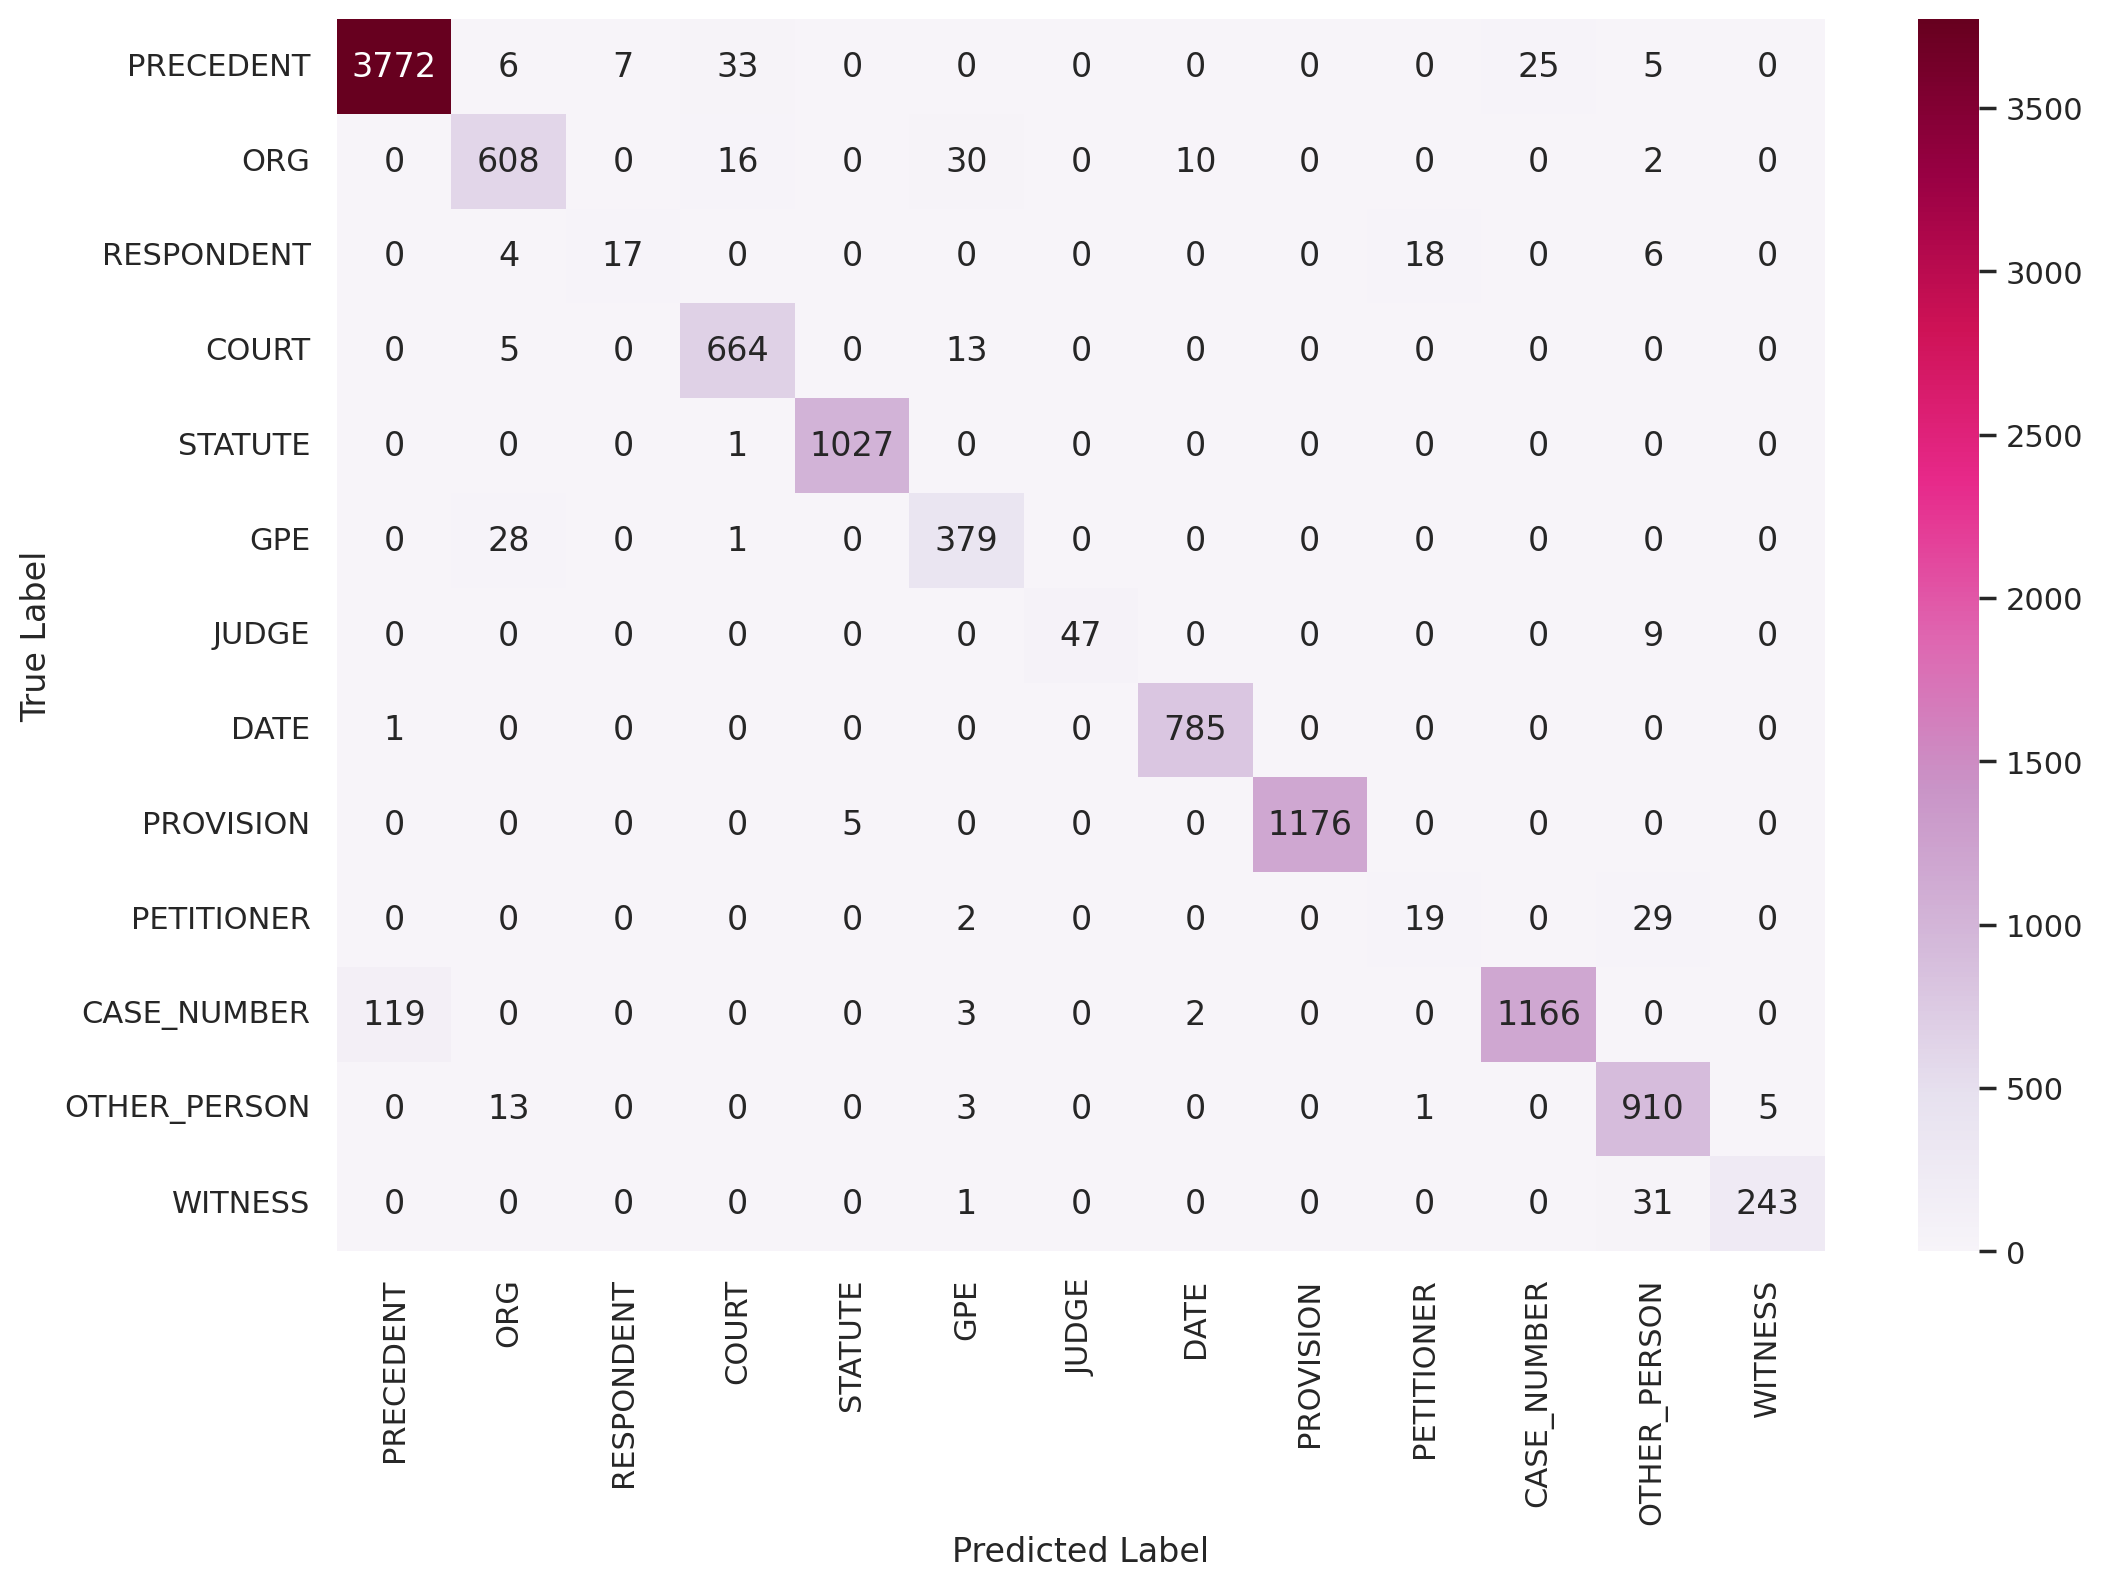

In [ ]:
generate_confusion_matrix(MODEL, val_dataloader, use_crf=False)